In [1]:
# n number of subsequences of a patient's notes
# c is scaling factor and controls influence of number of subsequences 
# use c= 2
# pmax is max probability of readmission
# pmean is mean probability of readmission
from datasets import load_dataset
import os
import numpy as np
import torch
from scipy.special import softmax
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
#tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

/home/ubuntu/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
def encode(examples):
     return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

In [6]:
# training model on tokenized and split data
class Dataset(torch.utils.data.Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val) for key, val in self.inputs[idx].items() if key != 'text'}
        item['labels'] = torch.tensor(int(self.labels[idx]['text']))
        return item

    def __len__(self):
        return len(self.labels)

In [7]:
def probability(test_dataset):
    # generates prediction from model
    train_pred = trainer.predict(test_dataset)
    pred = train_pred.predictions
    
    # softmax each row so each row sums to 1
    prob = softmax(pred, axis = 1)
    
    # find the mean probability of readmission
    meanprob = np.mean(prob,axis=0)[1]
    
    # find the max probability of readmission
    maxprob = np.amax(prob,axis=0)[1]
    
    n = pred.shape[0]
    
    # return mean, max, shape
    return meanprob, maxprob, n

In [8]:
def prepare_data(patientID):
    # loading features and labels per patient
    input_dataset = load_dataset('text', data_files={'test': '../../data/update/concatenated/patients/'+patientID})
    label_dataset = load_dataset('text', data_files={'test': '../../data/update/concatenated/labels/'+patientID})
    
    # applying encoding function to dataset
    input_dataset = input_dataset.map(encode, batched=True)
    
    # setting dataset to testing dataset
    test_dataset = Dataset(input_dataset['test'], label_dataset['test'])
    
    return test_dataset

In [9]:
# calculating readmit probability on per patient basis
def readmit_probability(maxprob,meanprob,n):
    # c accounts for patients with many notes
    c=2
    # weight as n/c
    scaling = n/c
    denominator = 1+scaling
    numerator = maxprob + (meanprob * scaling)
    
    probability = numerator/denominator
    return probability

In [287]:
import sklearn.metrics
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve, auc, RocCurveDisplay, average_precision_score, precision_recall_curve


# generating numpy array of all the real labels
def patient_labels(patients):
    labels = []
    for i in range(len(patients)):
        # taking label per patient
        with open('../../data/labels/'+ patients[i], 'r') as f:
            text = f.readline().strip()
            if text == '1':
                labels.append(1)
            elif text == '0':
                labels.append(0)
    
    label_array = np.asarray(labels)
            
    return label_array

# take in probabilities per patient array and threshold
# turn into list of labels of 0 or 1
def convert_probability(pred, threshold):
    labels= []
    for val in pred:
        if val>threshold:
            labels.append(1)
        else:
            labels.append(0)
            
    labels_array = np.asarray(labels)        
    return labels_array

# computing accuracy, f1, precision, recall, auroc
# parameters are the arrays of predicted labels, real labels, and predicted probabilities
def compute_metrics(pred_label, real_label, readmit_prob):
    labels = real_label
    preds = pred_label
    pred_prob = readmit_prob
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    roc = roc_auc_score(labels, pred_prob)
    auprc = average_precision_score(labels, pred_prob)
    fpr, tpr, thresholds = roc_curve(labels,pred_prob)
    roc_auc = auc(fpr, tpr)
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'auroc': roc,
        'auprc' : auprc,
    }

def compute_tpr(pred_label, real_label, readmit_prob):
    labels = real_label
    preds = pred_label
    predictions = readmit_prob
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    roc = roc_auc_score(labels, predictions)
    fpr, tpr, thresholds = roc_curve(labels,predictions)
    
    return fpr, tpr

def compute_prc(pred_label, real_label, readmit_prob):
    labels = real_label
    preds = pred_label
    predictions = readmit_prob
    precision, recall, thresholds = precision_recall_curve(labels, predictions)
    
    return precision, recall

In [14]:
with open('../../data/update/splits/valid_patients','r') as f:
    valid_list = f.read().splitlines()

with open('../../data/update/splits/test_patients','r') as f:
    test_list = f.read().splitlines()

In [11]:
# takes in list of patients from either valid split or test split
# lists are valid_list or test_list
def evaluate(split):
    # empty list of scalable readmission prediction probabilities
    patient_prob = []
    
    # load valid list for testing
    for i in range(len(split)):
        # load the patient datset
        test_dataset = prepare_data(split[i])

        # find the max and mean probability of readmission
        mean, maximum, n = probability(test_dataset)

        # calculate readmission probability per patient
        readmit = readmit_probability(mean,maximum,n)

        # add probabilities into list of all patient probabilities
        patient_prob.append(readmit)
        print(i)
    
    return patient_prob

In [255]:
# computing the metrics 
compute_metrics(s2prespred_labels, s2presreal_labels, s2prespred_prob)
sfpr, stpr = compute_tpr(s2prespred_labels, s2presreal_labels, s2prespred_prob)
sprec, srec = compute_prc(s2prespred_labels, s2presreal_labels, s2prespred_prob)

In [256]:
# computing the metrics 
compute_metrics(updatepred_labels, updatereal_labels, updatepred_prob)
bfpr, btpr = compute_tpr(updatepred_labels, updatereal_labels, updatepred_prob)
bprec, brec = compute_prc(updatepred_labels, updatereal_labels, updatepred_prob)

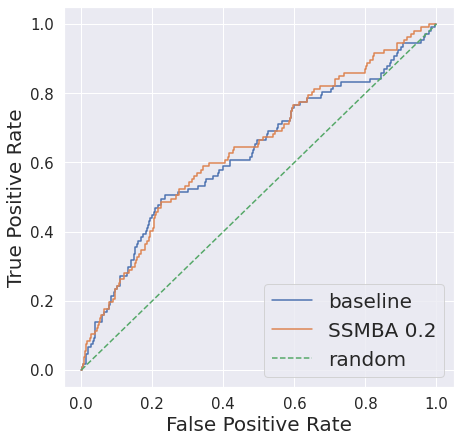

In [270]:
sns.set_style('white')
sns.set(rc={'figure.figsize':(7,7)})
x = np.linspace(0, 1, 10)
plt.plot(bfpr, btpr, label='baseline')
plt.plot(sfpr, stpr, label='SSMBA 0.2')
plt.plot(x,x,linestyle='dashed',label = 'random')
plt.xlabel("False Positive Rate", fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel("True Positive Rate", fontsize=20)
plt.yticks(fontsize=15)
plt.legend(loc=4, prop={'size': 20})
plt.show()

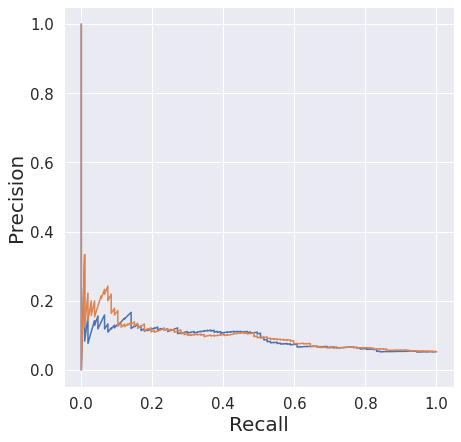

In [260]:
sns.set_style('white')
sns.set(rc={'figure.figsize':(7,7)})
plt.plot(brec, bprec, label = 'baseline')
plt.plot(srec, sprec, label = 'SSMBA')
plt.xlabel("Recall", fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel("Precision", fontsize=20)
plt.yticks(fontsize=15)
plt.show()

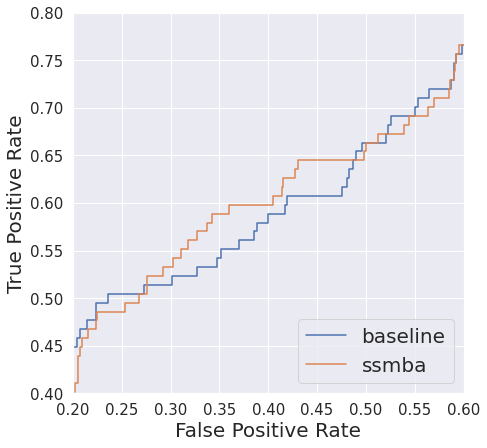

In [266]:
sns.set_style('whitegrid')
sns.despine()
sns.set(rc={'figure.figsize':(7,7)})
plt.plot(bfpr, btpr, label='baseline')
plt.plot(sfpr, stpr, label='ssmba')
plt.xlim(0.2, 0.6)
plt.ylim(0.4, 0.8)
plt.xlabel("False Positive Rate", fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel("True Positive Rate", fontsize=20)
plt.yticks(fontsize=15)
plt.legend(loc=4, prop={'size': 20})
plt.show()

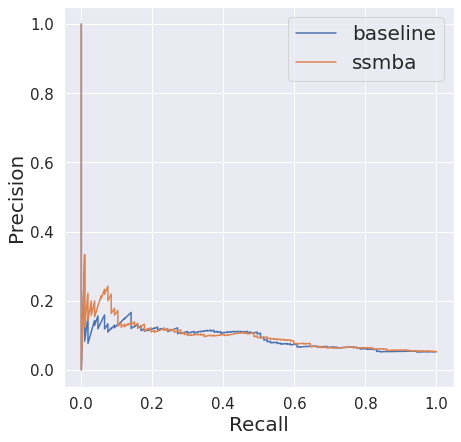

In [263]:
sns.set_style('white')
sns.set(rc={'figure.figsize':(7,7)})
plt.plot(brec, bprec, label='baseline')
plt.plot(srec, sprec, label='ssmba')
plt.xlabel("Recall", fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel("Precision", fontsize=20)
plt.yticks(fontsize=15)
plt.legend(loc=1, prop={'size': 20})
plt.show()

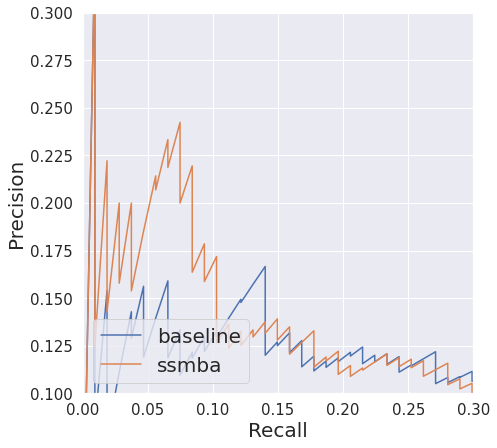

In [269]:
sns.set_style('white')
sns.set(rc={'figure.figsize':(7,7)})
plt.plot(brec, bprec, label='baseline')
plt.plot(srec, sprec, label='ssmba')
plt.xlim(0, .3)
plt.ylim(0.1, .3)
plt.xlabel("Recall", fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel("Precision", fontsize=20)
plt.yticks(fontsize=15)
plt.legend(loc=3, prop={'size': 20})
plt.show()

In [170]:
real_labels = np.load('../../old_models/orig_lr4e-5/test/real_labels.npz')
pred_prob = np.load('../../old_models/orig_lr4e-5/test/pred_prob.npz')
pred_labels = convert_probability(pred_prob, 0.85)

s2real_labels = np.load('../../old_models/ssmba_0.2/test/real_labels.npz')
s2pred_prob = np.load('../../old_models/ssmba_0.2/test/pred_prob.npz')
s2pred_labels = convert_probability(s2pred_prob, 0.8)

In [159]:
#old
compute_metrics(pred_labels, real_labels, pred_prob)

{'accuracy': 0.825625,
 'f1': 0.13622291021671828,
 'precision': 1.0,
 'recall': 0.07308970099667775,
 'auroc': 0.9686546512906682,
 'auprc': 0.9322846513734423}

In [160]:
#old
compute_metrics(s2pred_labels, s2real_labels, s2pred_prob)

{'accuracy': 0.96375,
 'f1': 0.901023890784983,
 'precision': 0.9263157894736842,
 'recall': 0.8770764119601329,
 'auroc': 0.97159072018087,
 'auprc': 0.9385224933946107}

In [288]:
compute_metrics(updatepred_labels, updatereal_labels, updatepred_prob)

ValueError: continuous format is not supported

In [236]:
s1softreal_labels = np.load('../../new_models/ssmba_0.1_soft/test/real_labels.npz')
s1softpred_prob = np.load('../../new_models/ssmba_0.1_soft/test/pred_prob.npz')
s1softpred_labels = convert_probability(s1softpred_prob, 0.55)

s1presreal_labels = np.load('../../new_models/ssmba_0.1_pres/test/real_labels.npz')
s1prespred_prob = np.load('../../new_models/ssmba_0.1_pres/test/pred_prob.npz')
s1prespred_labels = convert_probability(s1prespred_prob, 0.905)

s2softreal_labels = np.load('../../new_models/ssmba_0.2_soft/test/real_labels.npz')
s2softpred_prob = np.load('../../new_models/ssmba_0.2_soft/test/pred_prob.npz')
s2softpred_labels = convert_probability(s2softpred_prob, 0.56)

s2presreal_labels = np.load('../../new_models/ssmba_0.2_pres/test/real_labels.npz')
s2prespred_prob = np.load('../../new_models/ssmba_0.2_pres/test/pred_prob.npz')
s2prespred_labels = convert_probability(s2prespred_prob, 0.915)

s3softreal_labels = np.load('../../new_models/ssmba_0.3_soft/test/real_labels.npz')
s3softpred_prob = np.load('../../new_models/ssmba_0.3_soft/test/pred_prob.npz')
s3softpred_labels = convert_probability(s3softpred_prob, 0.615)

s3presreal_labels = np.load('../../new_models/ssmba_0.3_pres/test/real_labels.npz')
s3prespred_prob = np.load('../../new_models/ssmba_0.3_pres/test/pred_prob.npz')
s3prespred_labels = convert_probability(s3prespred_prob, 0.965)

s4softreal_labels = np.load('../../new_models/ssmba_0.4_soft/test/real_labels.npz')
s4softpred_prob = np.load('../../new_models/ssmba_0.4_soft/test/pred_prob.npz')
s4softpred_labels = convert_probability(s4softpred_prob, 0.675)

s4presreal_labels = np.load('../../new_models/ssmba_0.4_pres/test/real_labels.npz')
s4prespred_prob = np.load('../../new_models/ssmba_0.4_pres/test/pred_prob.npz')
s4prespred_labels = convert_probability(s4prespred_prob, 0.825)

In [246]:
updatereal_labels = np.load('../../new_models/orig/test/real_labels.npz')
updatepred_prob = np.load('../../new_models/orig/test/pred_prob.npz')
updatepred_labels = convert_probability(updatepred_prob, 0.705)

compute_metrics(s1presreal_labels, s1prespred_labels, s1prespred_prob)

In [211]:
compute_metrics(real_labels, pred_labels, pred_prob)

{'accuracy': 0.825625,
 'f1': 0.13622291021671828,
 'precision': 0.07308970099667775,
 'recall': 1.0,
 'auroc': 1.0,
 'auprc': 0.9999999999999998}

In [64]:
type(s1softpred_prob)

numpy.ndarray

In [218]:
def optimizef1 (real_labels, pred_prob):
    test = 0.0
    threshold = 0.0
    optimize = 0.0
    while threshold < 1.0:
        pred_labels = convert_probability(pred_prob, threshold)
        precision, recall, f1, _ = precision_recall_fscore_support(real_labels, pred_labels, average='binary')
        if f1 > test:
            test = f1
            optimize = threshold
        threshold += 0.005
    return optimize

In [126]:
def optimizeAccuracy (real_labels, pred_prob):
    test = 0.0
    threshold = 0.0
    optimize = 0.0
    while threshold < 1.0:
        pred_labels = convert_probability(pred_prob, threshold)
        #precision, recall, f1, _ = precision_recall_fscore_support(real_labels, pred_labels, average='binary')
        acc = accuracy_score(real_labels, pred_labels)
        if acc > test:
            test = acc
            optimize = threshold
        threshold += 0.01
    return optimize

In [225]:
print(optimizef1(s1softreal_labels,s1softpred_prob))
print(optimizef1(s2softreal_labels,s2softpred_prob))
print(optimizef1(s3softreal_labels,s3softpred_prob))
print(optimizef1(s4softreal_labels,s4softpred_prob))

/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/

0.5500000000000004


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/

0.5600000000000004


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/

0.6150000000000004
0.6750000000000005


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/

In [222]:
print(optimizef1(updatereal_labels,updatepred_prob))

0.7050000000000005


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/

In [226]:
print(optimizef1(s1presreal_labels,s1prespred_prob))
print(optimizef1(s2presreal_labels,s2prespred_prob))
print(optimizef1(s3presreal_labels,s3prespred_prob))
print(optimizef1(s4presreal_labels,s4prespred_prob))

/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/

0.9050000000000007


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/

0.9150000000000007


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9650000000000007
0.8250000000000006


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/

In [195]:
# load the patient datset
test1_dataset = prepare_data(valid_list[10])

# find the max and mean probability of readmission
mean1, maximum1, n1 = probability(test1_dataset)

# calculate readmission probability per patient
readmit1 = readmit_probability(mean1,maximum1,n1)


Using custom data configuration default
Reusing dataset text (/home/ubuntu/.cache/huggingface/datasets/text/default-a1ba682b66c55cb5/0.0.0/daf90a707a433ac193b369c8cc1772139bb6cca21a9c7fe83bdd16aad9b9b6ab)
Using custom data configuration default
Reusing dataset text (/home/ubuntu/.cache/huggingface/datasets/text/default-bf9a0a18d9225359/0.0.0/daf90a707a433ac193b369c8cc1772139bb6cca21a9c7fe83bdd16aad9b9b6ab)
Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/text/default-a1ba682b66c55cb5/0.0.0/daf90a707a433ac193b369c8cc1772139bb6cca21a9c7fe83bdd16aad9b9b6ab/cache-c52975535d677fb8.arrow


In [205]:
cntr = 0
for i in test_labels:
    if i == 1:
        cntr += 1

cntr

301

In [204]:
test_labels = patient_labels(test_list)